In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [18]:
# Define column names (32 names)
COLUMN_NAMES = [
    'ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 
    'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 
    'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 
    'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
    'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
FILE_NAME = 'wdbc.data.csv'

In [19]:
# Load the dataset (wdbc.data.csv)
df = pd.read_csv('wdbc.data.csv')

In [20]:
# A. Drop non-predictive columns
df.drop('id', axis=1, inplace=True)
if 'Unnamed: 32' in df.columns:
    df.drop('Unnamed: 32', axis=1, inplace=True)

# B. Target Encoding (M=1, B=0)
le = LabelEncoder()
df['diagnosis_encoded'] = le.fit_transform(df['diagnosis'])
# Separate features (X) and target (y)
X = df.drop(['diagnosis', 'diagnosis_encoded'], axis=1)
y = df['diagnosis_encoded']

# C. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame for coefficient analysis
X_aligned = pd.DataFrame(X_scaled, columns=X.columns)

# D. Data Splitting (70% Train and 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X_aligned, 
                                                    y, test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
print(f"Data successfully loaded and preprocessed.")
print(f"Training data: {X_train.shape[0]} samples")
print(f"Testing data:  {X_test.shape[0]} samples")

Data successfully loaded and preprocessed.
Training data: 398 samples
Testing data:  171 samples


In [21]:
# Model Training and Prediction
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)

# Generate predictions and probabilities on the test set
y_pred = lr_model.predict(X_test)
# We need y_proba (probability of class 1) for the ROC curve
y_prob = lr_model.predict_proba(X_test)[:, 1]

print("Model training complete.")

Model training complete.


In [22]:
# Result and Evaluation
print("MODEL RESULTS AND EVALUATION")

# A. Performace Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFINAL MODEL ACCURACY ON TEST SET: {accuracy:.4f}")
print("-" * 60)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))

# B. Feature Interpretation (Coefficient analysis)
coefficients = pd.DataFrame({
    'Feature': X_aligned.columns,
    'Coefficient': lr_model.coef_[0]
})
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients_sorted = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)
print("\nTOP 5 MOST PREDICTIVE FEATURES (By Coefficient Magnitude):")
print(coefficients_sorted[['Feature', 'Coefficient']].head(5).to_string(index=False))

MODEL RESULTS AND EVALUATION

FINAL MODEL ACCURACY ON TEST SET: 0.9766
------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.97      0.99      0.98       107
Malignant (1)       0.98      0.95      0.97        64

     accuracy                           0.98       171
    macro avg       0.98      0.97      0.97       171
 weighted avg       0.98      0.98      0.98       171


TOP 5 MOST PREDICTIVE FEATURES (By Coefficient Magnitude):
       Feature  Coefficient
 texture_worst     1.362210
     radius_se     1.235548
symmetry_worst     1.061038
       area_se     0.921562
    area_worst     0.914994


GENERATING VISUALIZATIONS


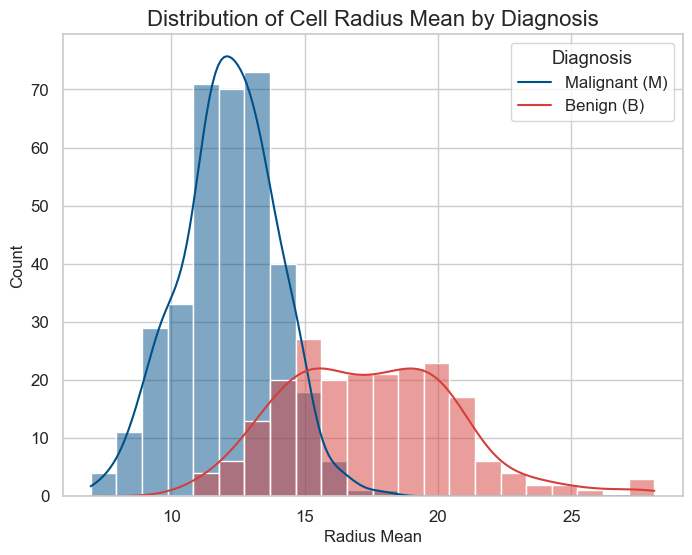

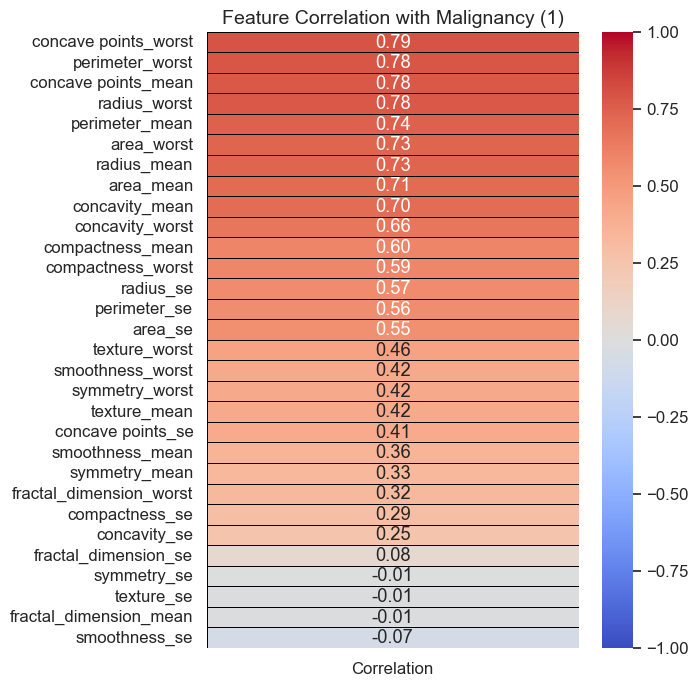

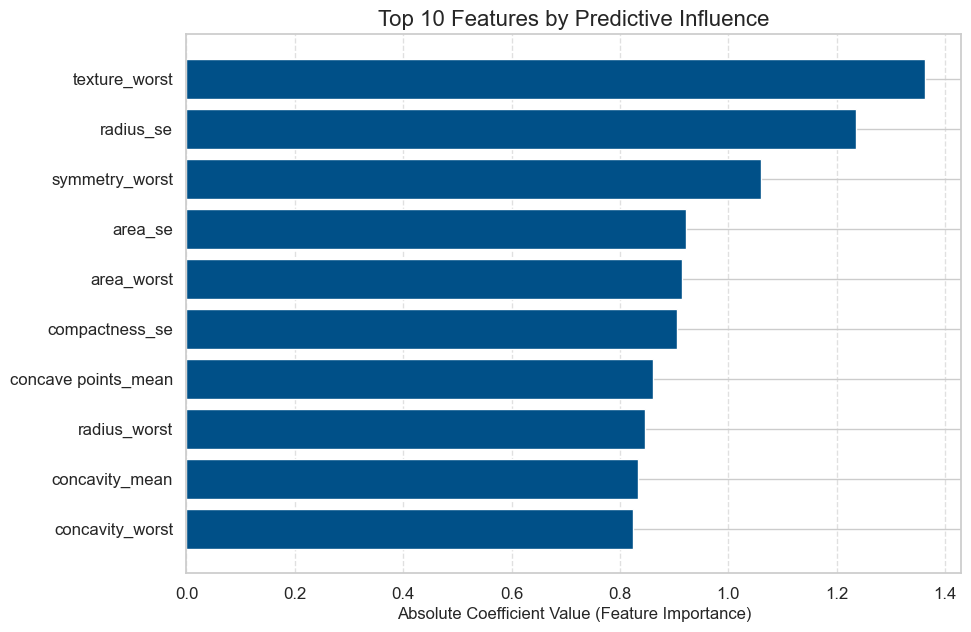

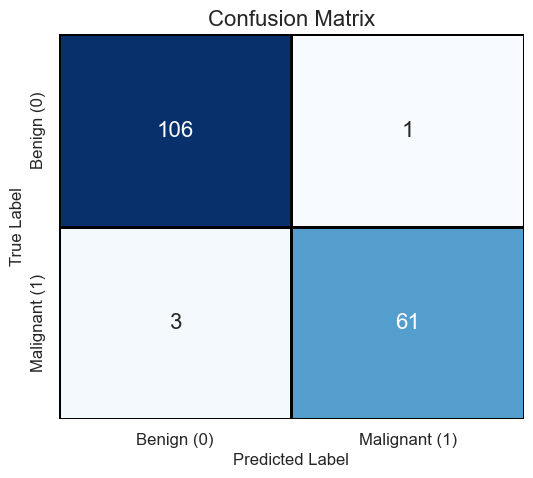

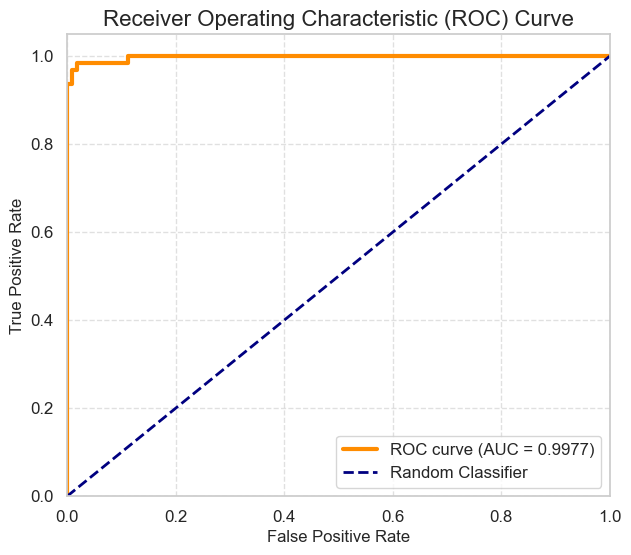

In [29]:
print("GENERATING VISUALIZATIONS")

# 1. Distribution of a Key Feature
# Using diagnosis ('M'/'B') for hue, matched to a string-based palette.
plt.figure(figsize=(8, 6))
sns.histplot(df, x='radius_mean', hue='diagnosis', kde=True, palette={'B': '#005088', 'M': '#D43F3A'})
plt.title('Distribution of Cell Radius Mean by Diagnosis', fontsize=16)
plt.xlabel('Radius Mean', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Diagnosis', labels=['Malignant (M)', 'Benign (B)'])
plt.savefig('Feature_Distribution.png')
plt.show()

# 2. Feature Correlation Heatmap
correlation_with_target = df.corr(numeric_only=True)['diagnosis_encoded'].drop('diagnosis_encoded').sort_values(ascending=False)
plt.figure(figsize=(6, 8))
sns.heatmap(
    correlation_with_target.to_frame(name='Correlation'),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    vmin=-1, vmax=1
)
plt.title('Feature Correlation with Malignancy (1)', fontsize=14)
plt.savefig('Correlation_Heatmap.png')
plt.show()

# 3. Bar Plot of Top 10 Coefficients
top_10_coef = coefficients_sorted.head(10).sort_values(by='Absolute_Coefficient', ascending=True)
plt.figure(figsize=(10, 7))
plt.barh(top_10_coef['Feature'], top_10_coef['Absolute_Coefficient'], color='#005088')
plt.xlabel('Absolute Coefficient Value (Feature Importance)', fontsize=12)
plt.title('Top 10 Features by Predictive Influence', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('Coefficient_Importance.png')
plt.show()

# 4. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign (0)', 'Malignant (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, 
    annot=True, 
    annot_kws={"size": 16},
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels, 
    cbar=False,
    linewidths=1,
    linecolor='black'
)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('Confusion_Matrix.png')
plt.show()

# 5. ROC Curve Plot and AUC Score
# Note: roc_auc was calculated in Cell 5, but we recreate the variables here for the plot.
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(7, 6))
plt.plot(
    false_positive_rate, 
    true_positive_rate, 
    color='darkorange', 
    lw=3, 
    label=f'ROC curve (AUC = {roc_auc:.4f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('ROC_Curve.png')
plt.show()